# Number of Simulations vs. Pareto Ranks by Team

This notebook explores the number of simulations that were done by team and grouped by 
their experimental condition and plots them against their Pareto ranks.

In [1]:
import sys
import os.path

sys.path.append("../CommonModules") # go to parent dir/CommonModules

import Learning2019GTL.Globals as Globals
import Learning2019GTL.DataConnector as DataConnector

data_map = Globals.FileNameMaps()

TEAM_MAP = dict([[v,k] for k,v in data_map.CSV_MAP.items()])

DATA_FILE = os.path.expanduser("~/Learning2019Data/PostProcessingResults/TeamNumSimulationsByFile.csv")
DATA_FILE_PARETO = os.path.expanduser("~/Learning2019Data/PostProcessingResults/ParetoRankingByFile.csv")

import csv
import numpy as np

conditions = ['A - control (discuss conference) at beginning', 'B - strategy at beginning', 'D - strategy at mid']

class AnalyzedData:
    team_str   = ''
    team = None
    unique_sims = -1
    total_sims  = -1
    condition  = ''
    pareto_ranks_coarse = -1 # one or more solutions to be the same rank
    pareto_ranks_fine   = -1 # more solutions in the front == better rank
    pareto_ranks_ordinal = -1 # ordinal from pareto_ranks_fine
    
    def __str__(self):
        return str(self.team) + f", total_sims: {self.total_sims}, " +\
            f"unique_sims: {self.unique_sims}, " +\
            f"pareto_rank: {self.pareto_ranks_fine}, pareto_rank_ordinal: {self.pareto_ranks_ordinal}"
    
analyzed_data = {} # empty dictionary

with open(DATA_FILE, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        team_file = row['File']
        team_str = TEAM_MAP[team_file]
        t = DataConnector.Team()
        condition = t.getCondition(team_str)[0]
        #print(row)
        #print(condition
        if team_str in analyzed_data.keys():
            datum = analyzed_data[team_str]
        else:
            datum = AnalyzedData()
            analyzed_data[team_str] = datum
            datum.team_str = team_str
            datum.team = t
            t.getTeamByID(t.team_id)
            
        datum.condition = condition
        datum.unique_sims = int(row[' UniqueSims'])
        datum.total_sims = int(row[' TotalSims'])

## Checking that I can get back data grouped by conditions for plotting

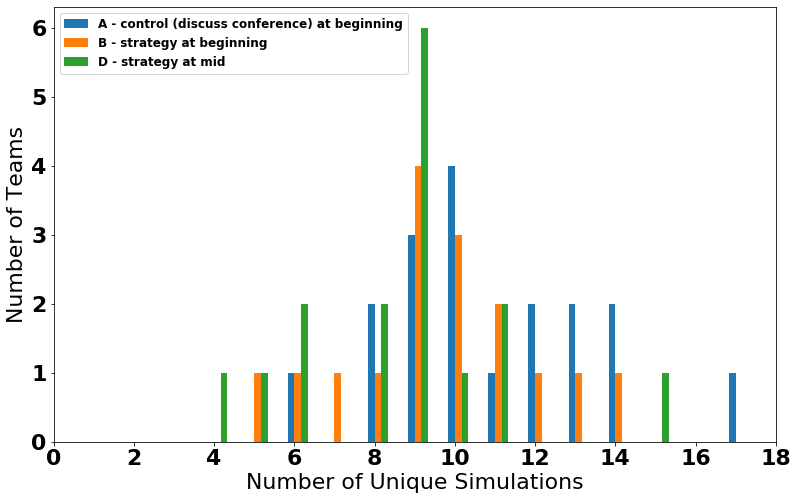

In [2]:
uniqueSimsA = [analyzed_data[k].unique_sims for k in analyzed_data.keys() if analyzed_data[k].condition == 'A' ]
uniqueSimsB = [analyzed_data[k].unique_sims for k in analyzed_data.keys() if analyzed_data[k].condition == 'B' ]
uniqueSimsD = [analyzed_data[k].unique_sims for k in analyzed_data.keys() if analyzed_data[k].condition == 'D' ]

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

golden_ratio = np.array([1.61803398875, 1])
plt.figure(figsize=golden_ratio*8)

uniqueSimsA = np.array(uniqueSimsA)
uniqueSimsB = np.array(uniqueSimsB)
uniqueSimsD = np.array(uniqueSimsD)

plt.hist(uniqueSimsA-1/6, bins=np.arange(0, 18, 1/6), density=False)
plt.hist(uniqueSimsB+0/6, bins=np.arange(0, 18, 1/6), density=False)
plt.hist(uniqueSimsD+1/6, bins=np.arange(0, 18, 1/6), density=False)
plt.xlim([0, 18])
plt.legend(conditions, fontsize=12, loc=2)
plt.ylabel('Number of Teams')
plt.xlabel('Number of Unique Simulations')
plt.show()


## Loading Pareto Ranks

In [3]:
def getPRank(row):
    rank = -1
    for p in range(17):
        key = f'P{p}'
        if int(row[key]) > 0:
            rank = p
            break
            
    return rank

def getPRankWithNum(row):
    rank = -1
    for p in range(17):
        key = f'P{p}'
        val = int(row[key])
        if val > 0:
            rank = p + 1/(val + 1)
            break
            
    return rank

with open(DATA_FILE_PARETO, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        team_file = row['File']
        team_str = TEAM_MAP[team_file]
        rank_coarse = getPRank(row)
        rank_fine   = getPRankWithNum(row)
        datum = analyzed_data[team_str] # we should have all the data points in the number of sims loop    
        datum.pareto_ranks_coarse = rank_coarse
        datum.pareto_ranks_fine   = rank_fine

## Number of unique simulations verses pareto ranks

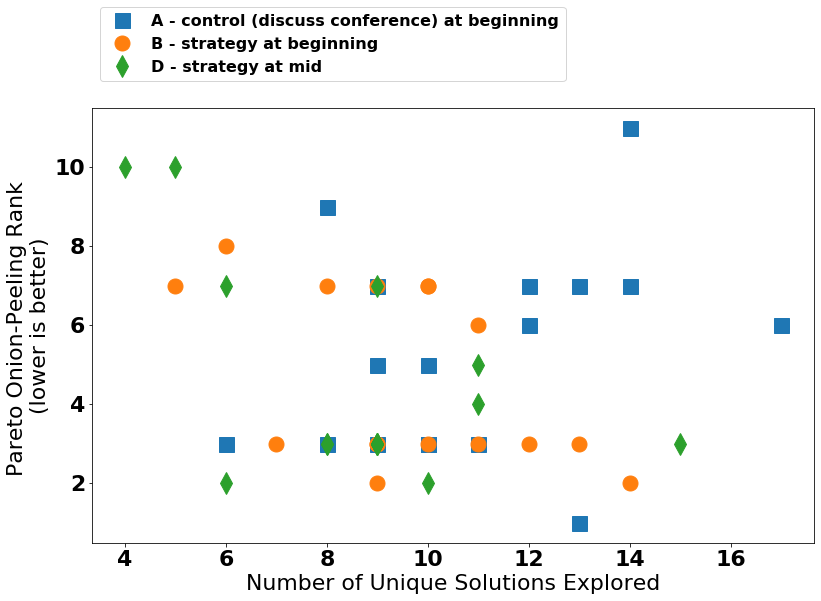

In [4]:
paretoRanksA = [analyzed_data[k].pareto_ranks_fine for k in analyzed_data.keys() if analyzed_data[k].condition == 'A' ]
paretoRanksB = [analyzed_data[k].pareto_ranks_fine for k in analyzed_data.keys() if analyzed_data[k].condition == 'B' ]
paretoRanksD = [analyzed_data[k].pareto_ranks_fine for k in analyzed_data.keys() if analyzed_data[k].condition == 'D' ]

allData = paretoRanksA + paretoRanksB + paretoRanksD

import scipy.stats
rankedData = scipy.stats.rankdata(allData, method='dense')
paretoRanksA = rankedData[0:len(paretoRanksA)]
paretoRanksB = rankedData[len(paretoRanksA):len(paretoRanksA)+len(paretoRanksB)]
paretoRanksD = rankedData[len(paretoRanksA)+len(paretoRanksB):]

plt.figure(figsize=golden_ratio*8)
plt.plot(uniqueSimsA, paretoRanksA, marker="s", linewidth=0, markersize=15)
plt.plot(uniqueSimsB, paretoRanksB, marker="o", linewidth=0, markersize=15)
plt.plot(uniqueSimsD, paretoRanksD, marker="d", linewidth=0, markersize=15)
plt.xlabel("Number of Unique Solutions Explored")
plt.ylabel("Pareto Onion-Peeling Rank \n(lower is better)")
plt.legend(conditions, fontsize=16, loc='upper left', bbox_to_anchor=(0,1.25))
plt.show()



In [5]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
linear_pred_X = np.arange(1, 20).reshape(-1, 1)
linear_regressor.fit(uniqueSimsA.reshape(-1,1), paretoRanksA)  # perform linear regression
linearA_pred = linear_regressor.predict(linear_pred_X)  # make predictions
linear_regressor.fit(uniqueSimsB.reshape(-1,1), paretoRanksB)  # perform linear regression
linearB_pred = linear_regressor.predict(linear_pred_X)  # make predictions
linear_regressor.fit(uniqueSimsD.reshape(-1,1), paretoRanksD)  # perform linear regression
linearD_pred = linear_regressor.predict(linear_pred_X)  # make predictions

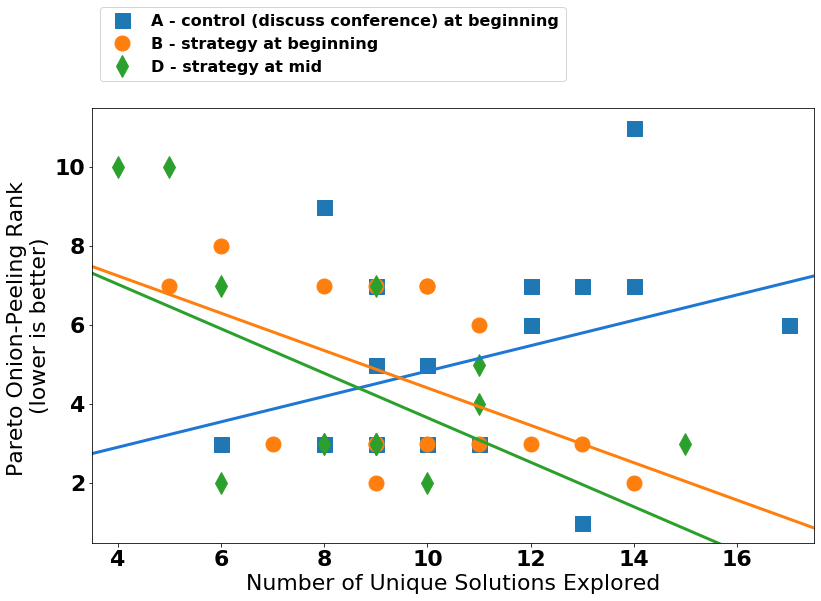

In [6]:
plt.figure(figsize=golden_ratio*8)
plt.plot(uniqueSimsA, paretoRanksA, marker="s", linewidth=0, markersize=15)
plt.plot(uniqueSimsB, paretoRanksB, marker="o", linewidth=0, markersize=15)
plt.plot(uniqueSimsD, paretoRanksD, marker="d", linewidth=0, markersize=15)
plt.plot(linear_pred_X, linearA_pred, color='#1f77d4', linewidth=3)
plt.plot(linear_pred_X, linearB_pred, color='#ff7f0e', linewidth=3)
plt.plot(linear_pred_X, linearD_pred, color='#2ca02c', linewidth=3)
plt.xlabel("Number of Unique Solutions Explored")
plt.ylabel("Pareto Onion-Peeling Rank \n(lower is better)")
plt.legend(conditions, fontsize=16, loc='upper left', bbox_to_anchor=(0,1.25))
plt.ylim([0.5, 11.5])
plt.xlim([3.5, 17.5])
plt.show()

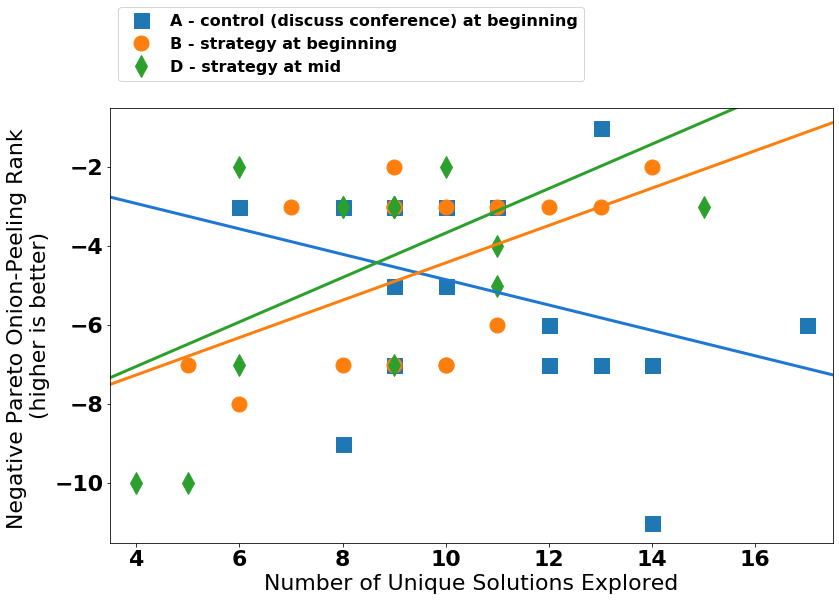

In [7]:
plt.figure(figsize=golden_ratio*8)
plt.plot(uniqueSimsA, -paretoRanksA, marker="s", linewidth=0, markersize=15)
plt.plot(uniqueSimsB, -paretoRanksB, marker="o", linewidth=0, markersize=15)
plt.plot(uniqueSimsD, -paretoRanksD, marker="d", linewidth=0, markersize=15)
plt.plot(linear_pred_X, -linearA_pred, color='#1f77d4', linewidth=3)
plt.plot(linear_pred_X, -linearB_pred, color='#ff7f0e', linewidth=3)
plt.plot(linear_pred_X, -linearD_pred, color='#2ca02c', linewidth=3)
plt.xlabel("Number of Unique Solutions Explored")
plt.ylabel("Negative Pareto Onion-Peeling Rank \n(higher is better)")
plt.legend(conditions, fontsize=16, loc='upper left', bbox_to_anchor=(0,1.25))
plt.ylim([-11.5, -0.5])
plt.xlim([3.5, 17.5])
plt.show()

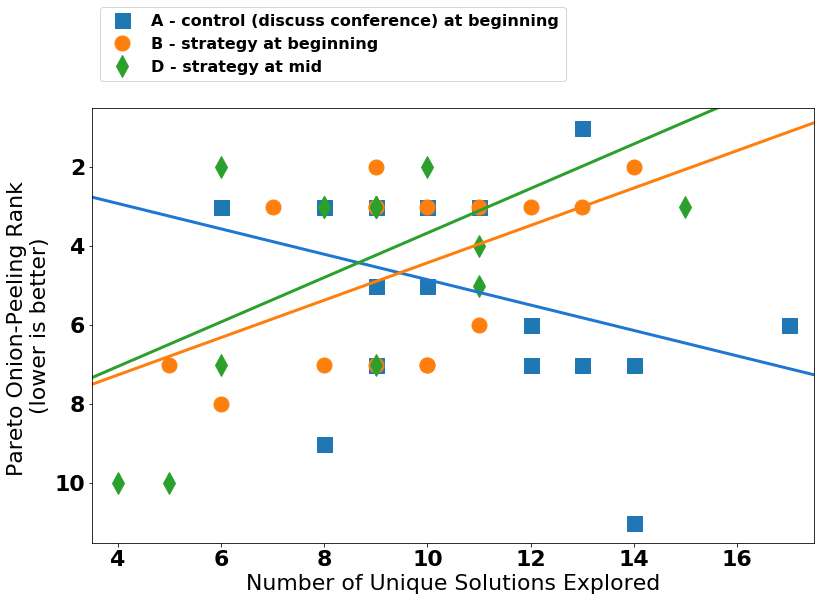

In [8]:
plt.figure(figsize=golden_ratio*8)
plt.plot(uniqueSimsA, paretoRanksA, marker="s", linewidth=0, markersize=15)
plt.plot(uniqueSimsB, paretoRanksB, marker="o", linewidth=0, markersize=15)
plt.plot(uniqueSimsD, paretoRanksD, marker="d", linewidth=0, markersize=15)
plt.plot(linear_pred_X, linearA_pred, color='#1f77d4', linewidth=3)
plt.plot(linear_pred_X, linearB_pred, color='#ff7f0e', linewidth=3)
plt.plot(linear_pred_X, linearD_pred, color='#2ca02c', linewidth=3)
plt.xlabel("Number of Unique Solutions Explored")
plt.ylabel("Pareto Onion-Peeling Rank \n(lower is better)")
plt.legend(conditions, fontsize=16, loc='upper left', bbox_to_anchor=(0,1.25))
plt.ylim([11.5, 0.5])
plt.xlim([3.5, 17.5])
plt.show()

# Teams that are highly and not-so-highly ranked in the various groups

In [9]:
for key in analyzed_data:
    datum = analyzed_data[key]
    print(datum)

 Day: M, Session: S3, Room: R2, Station: 7 Condition: D, DbTeamID: 15, total_sims: 7, unique_sims: 6, pareto_rank: 0.3333333333333333, pareto_rank_ordinal: -1
 Day: M, Session: S1, Room: R1, Station: 4 Condition: A, DbTeamID: 4, total_sims: 10, unique_sims: 9, pareto_rank: 0.5, pareto_rank_ordinal: -1
 Day: T, Session: S2, Room: R2, Station: 8 Condition: D, DbTeamID: 34, total_sims: 5, unique_sims: 5, pareto_rank: 4.333333333333333, pareto_rank_ordinal: -1
 Day: T, Session: S1, Room: R1, Station: 4 Condition: B, DbTeamID: 26, total_sims: 13, unique_sims: 11, pareto_rank: 1.3333333333333333, pareto_rank_ordinal: -1
 Day: T, Session: S1, Room: R2, Station: 7 Condition: D, DbTeamID: 27, total_sims: 6, unique_sims: 6, pareto_rank: 1.5, pareto_rank_ordinal: -1
 Day: M, Session: S3, Room: R1, Station: 1 Condition: A, DbTeamID: 12, total_sims: 9, unique_sims: 8, pareto_rank: 0.5, pareto_rank_ordinal: -1
 Day: T, Session: S3, Room: R1, Station: 3 Condition: D, DbTeamID: 39, total_sims: 10, uni

In [22]:
allData = [analyzed_data[k].pareto_ranks_fine for k in analyzed_data.keys()]
rankedData = scipy.stats.rankdata(allData, method='dense')
i = 0
for key, value in analyzed_data.items():
    value.pareto_ranks_ordinal = rankedData[i]
    i += 1
    

In [23]:
for key in analyzed_data:
    datum = analyzed_data[key]
    print(datum)

 Day: M, Session: S3, Room: R2, Station: 7 Condition: D, DbTeamID: 15, total_sims: 7, unique_sims: 6, pareto_rank: 0.3333333333333333, pareto_rank_ordinal: 2
 Day: M, Session: S1, Room: R1, Station: 4 Condition: A, DbTeamID: 4, total_sims: 10, unique_sims: 9, pareto_rank: 0.5, pareto_rank_ordinal: 3
 Day: T, Session: S2, Room: R2, Station: 8 Condition: D, DbTeamID: 34, total_sims: 5, unique_sims: 5, pareto_rank: 4.333333333333333, pareto_rank_ordinal: 10
 Day: T, Session: S1, Room: R1, Station: 4 Condition: B, DbTeamID: 26, total_sims: 13, unique_sims: 11, pareto_rank: 1.3333333333333333, pareto_rank_ordinal: 6
 Day: T, Session: S1, Room: R2, Station: 7 Condition: D, DbTeamID: 27, total_sims: 6, unique_sims: 6, pareto_rank: 1.5, pareto_rank_ordinal: 7
 Day: M, Session: S3, Room: R1, Station: 1 Condition: A, DbTeamID: 12, total_sims: 9, unique_sims: 8, pareto_rank: 0.5, pareto_rank_ordinal: 3
 Day: T, Session: S3, Room: R1, Station: 3 Condition: D, DbTeamID: 39, total_sims: 10, unique_s

In [25]:
paretoRanksA = [analyzed_data[k].pareto_ranks_ordinal for k in analyzed_data.keys() if analyzed_data[k].condition == 'A' ]
paretoRanksB = [analyzed_data[k].pareto_ranks_ordinal for k in analyzed_data.keys() if analyzed_data[k].condition == 'B' ]
paretoRanksD = [analyzed_data[k].pareto_ranks_ordinal for k in analyzed_data.keys() if analyzed_data[k].condition == 'D' ]

uniqueSimsA = [analyzed_data[k].un for k in analyzed_data.keys() if analyzed_data[k].condition == 'A' ]
uniqueSimsB = [analyzed_data[k].uniqueSimsB for k in analyzed_data.keys() if analyzed_data[k].condition == 'B' ]
uniqueSimsD = [analyzed_data[k].uniqueSimsD for k in analyzed_data.keys() if analyzed_data[k].condition == 'D' ]


AttributeError: 'AnalyzedData' object has no attribute 'uniqueSimsA'